# Processo Seletivo SciCrop para Estágio em Data Science 

## Classificação Preditiva de Danos em Plantação

Saulo Giovani de Matos Silva 

saulo.giovani.ms@gmail.com

<a href="linkedin.com/in/saulo-giovani">LinkedIn</a>

A resolução do problema de classificação focou em três características dos dados fornecidos: **1)** a mistura de valores numéricos, categóricos e binários; **2)** o desbalanço de exemplos na variável de predição; **3)** e a ausência de valores em algumas linhas de uma única variável. 

**1)** Como a mistura de variáveis numéricas, categóricas e binárias dificulta a criação de fronteiras pelo KNN e pela Regressão Logística descartei esses métodos. Sabendo que as variáveis seguem leis de probabilidade diferentes pela própria natureza dos dados, também descartei o classificador Naive Bayes que geralmente utiliza a mesma lei para todas as variáveis. Escolhi o Randrom Forest porque geralmente responde bem a variáveis de naturezas diferentes.

**2)** Visto que a categoria _Sem Danos_ representa mais de 80% dos valores, apliquei o método Random Forest com oversampling para tentar compensar esse desbalanço. Além disso, foquei na Confusion matrix como referência ao invés da acurácia em si. Por último levei em consideração que é mais interessante que os erros tendam mais para dizer que tem dano onde não tem do que o contrário, pois representaria um cenário mais negativo e permite que a empresa se prepare para riscos maiores.

**3)** Como as classes _Danos causados por outros motivos_ e _Danos gerados pelos pesticidas_ são tão pouco numerosas em comparação com a classe _Sem Danos_, seria um desperdício deixar de classificar as linhas que não têm valor atribuido. Uma vez que é apenas a variável "Semanas_Utilizando", separei essas linhas para aplicar um método que não leva em consideração essa variável.

Farei outros comentários ao longo do código, vamos lá!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
Safra1819 = pd.read_csv('Safra_2018-2019.csv', index_col=0)
Safra1819.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,SCROP00005,342,1,0,1,0,0.0,0,2,1


# Compreendendo os dados

Olhei a quantidade de valores diferentes para ter uma ideia da dispersão de valores em cada classe, além disso procurei pela presença de NaN e encontrei apenas em "Semanas_Utilizando". Vemos pelas porcentagens que a proporção das classes a serem classificadas não é fortemente impactada pela ausência das linhas com NaN.

In [3]:
Safra1819.nunique()

Identificador_Agricultor    80000
Estimativa_de_Insetos          71
Tipo_de_Cultivo                 2
Tipo_de_Solo                    2
Categoria_Pesticida             3
Doses_Semana                   20
Semanas_Utilizando             64
Semanas_Sem_Uso                51
Temporada                       3
dano_na_plantacao               3
dtype: int64

In [4]:
Safra1819.isnull().any()

Identificador_Agricultor    False
Estimativa_de_Insetos       False
Tipo_de_Cultivo             False
Tipo_de_Solo                False
Categoria_Pesticida         False
Doses_Semana                False
Semanas_Utilizando           True
Semanas_Sem_Uso             False
Temporada                   False
dano_na_plantacao           False
dtype: bool

In [5]:
print("Fração de linhas com valores faltantes %f" % (1 - len(Safra1819.dropna())/len(Safra1819)))
print("--------- COM NaN")
print("Fração Sem Danos %f" % (sum(Safra1819['dano_na_plantacao']==0)/len(Safra1819)))
print("Fração Danos por Outros %f" % (sum(Safra1819['dano_na_plantacao']==1)/len(Safra1819)))
print("Fração Danos por Pesticida %f" % (sum(Safra1819['dano_na_plantacao']==2)/len(Safra1819)))
print("--------- SEM NaN")
print("Fração Sem Danos %f" % (sum(Safra1819.dropna()['dano_na_plantacao']==0)/len(Safra1819.dropna())))
print("Fração Danos por Outros %f" % (sum(Safra1819.dropna()['dano_na_plantacao']==1)/len(Safra1819.dropna())))
print("Fração Danos por Pesticida %f" % (sum(Safra1819.dropna()['dano_na_plantacao']==2)/len(Safra1819.dropna())))

Fração de linhas com valores faltantes 0.100688
--------- COM NaN
Fração Sem Danos 0.833950
Fração Danos por Outros 0.139788
Fração Danos por Pesticida 0.026263
--------- SEM NaN
Fração Sem Danos 0.833956
Fração Danos por Outros 0.140038
Fração Danos por Pesticida 0.026006


## Relação entre os Dados 

O Heatmap dá uma ideia geral das relações entre as variáveis, vemos que a "Temporada" praticamente não se relaciona com com as outras. Vemos que "Semanas_Utilizando" é a variável mais correlata com "danos_na_plantação", logo não é interessante deixar de usar essa coluna apesar de ser a única com valores NaN. É importante lembrar que a correlação usual não é o ideal para comparar variáveis binárias e categóricas. 

### Correlação

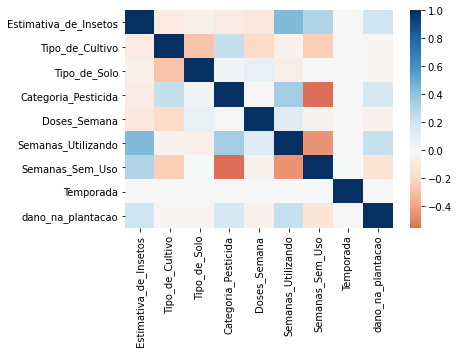

In [6]:
sns.heatmap(Safra1819.corr(), cmap='RdBu',center=0)
plt.show()

In [7]:
Safra1819.corr().sort_values(by='dano_na_plantacao', ascending=False)['dano_na_plantacao']

dano_na_plantacao        1.000000
Semanas_Utilizando       0.233523
Estimativa_de_Insetos    0.203290
Categoria_Pesticida      0.172943
Temporada               -0.002233
Tipo_de_Cultivo         -0.017228
Tipo_de_Solo            -0.021176
Doses_Semana            -0.030476
Semanas_Sem_Uso         -0.133115
Name: dano_na_plantacao, dtype: float64

### Média e Desvio Padrão 2018-2019

Temos a média (em cima) e o desvio padrão (em baixo) por classe de "dano_na_plantação" e vemos muitas variáveis se sobrepõem fortemente, visto que apresentam médias próximas e que a distância das médias é bem menor que o desvio padrão.

In [8]:
Safra1819.dropna().pivot_table(index='dano_na_plantacao', aggfunc=np.mean)

,Categoria_Pesticida,Doses_Semana,Estimativa_de_Insetos,Semanas_Sem_Uso,Semanas_Utilizando,Temporada,Tipo_de_Cultivo,Tipo_de_Solo
dano_na_plantacao,,,,,,,,
0,2.233504,26.112019,1317.262388,10.075251,27.371823,1.897415,0.287421,0.462008
1,2.419653,24.211911,1842.925261,7.566948,34.629975,1.891911,0.252308,0.430471
2,2.569749,26.082309,1739.869588,3.341529,37.994121,1.902726,0.295564,0.423838


In [9]:
Safra1819.dropna().pivot_table(index='dano_na_plantacao', aggfunc=np.std)

,Categoria_Pesticida,Doses_Semana,Estimativa_de_Insetos,Semanas_Sem_Uso,Semanas_Utilizando,Temporada,Tipo_de_Cultivo,Tipo_de_Solo
dano_na_plantacao,,,,,,,,
0,0.426751,15.705731,811.592545,9.814837,11.623995,0.702668,0.452564,0.498559
1,0.577841,14.626725,928.633064,10.332105,14.084724,0.702762,0.434358,0.495167
2,0.616462,14.767056,837.612253,6.653726,14.244258,0.684549,0.456418,0.494297


# Visualização com PCA

Para tentar compreender melhor a distinção dos dados, realizei uma PCA e plotei as classes segundo as duas componentem principais. Vemos que a componente mais importante não representa nem 25% da informação fornecida pelos dados. Vemos também que são necessárias 6 das 8 componentes para obter 90% da informação dos dados.

P Gráfico mostra como as classes com menos valores estão "mergulhadas" na classe _Sem Danos_. Não há uma fronteira facilmente visível com base nas duas componentes principais, podemos ter uma intuição de que não é fácil separar esses dados.

In [10]:
x = Safra1819.dropna().iloc[:,1:-1]
y = Safra1819.dropna().iloc[:,-1].values
print("Shape of x: %s" % str(np.shape(x)))
print("Shape of y: %s" % str(np.shape(y)))

Shape of x: (71945, 8)
Shape of y: (71945,)


Soma do peso das seis componentes principais: 0.918865
Vetor das 8 componentes em ordem de peso:
[0.2489108  0.18174806 0.16617488 0.12501823 0.11809996 0.07891265
 0.05877627 0.02235916]


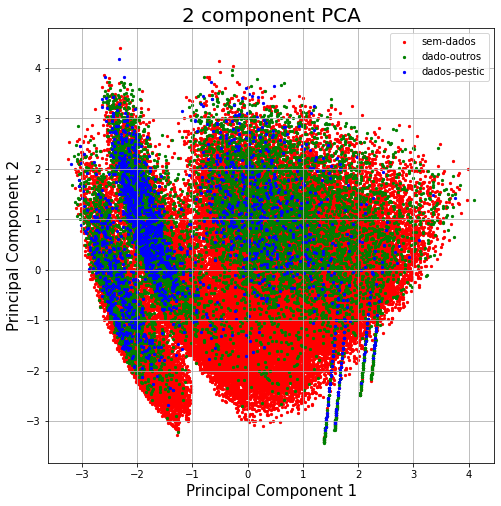

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_pca = StandardScaler().fit_transform(x)

pca = PCA(n_components=8)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8'])

print("Soma do peso das seis componentes principais: %f" % np.sum(pca.explained_variance_ratio_[:6]))
print("Vetor das 8 componentes em ordem de peso:")
print(pca.explained_variance_ratio_)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = y == target
    ax.scatter(principalDf.loc[indicesToKeep, 'pc1']
               , principalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 5)
ax.legend(['sem-dados','dado-outros','dados-pestic'])
ax.grid()

# Processamento ML

Nessa seção, realiza-se um _Dummy Test_ para mostrar como a acurácia não é confiável e depois aplicamos o Random Forest e o Random Forest com Oversampling.

As Confusion Matrices apresentadas foram plotadas normalizadas, de modo que a soma de cada coluna vale 1. Quando maior os valores na diagonal principal, melhor o desempenho.

In [12]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0)

## Dummy Test

Vemos que a repetição da na classe _Sem Danos_ em todas as previsões garante 83% de acurácia, logo é um valor artificial.

0.8349240177909563


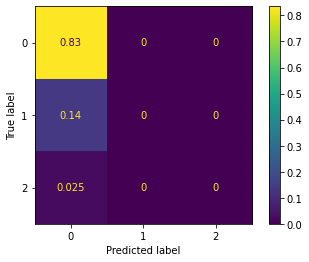

In [14]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking accuracy
print(accuracy_score(y_test, dummy_pred))

plot_confusion_matrix(dummy, X_test, y_test,normalize = 'pred')  # doctest: +SKIP
plt.show()

## Random Forest

0.8242216456634545


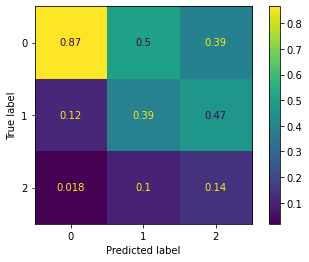

In [15]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(rf, X_test, y_test,normalize = 'pred')  # doctest: +SKIP
plt.show()

## Random Forest com Oversampling

Vemos nessa função a flag 'sampling_strategy='not majority', que faz com que os valores de _Sem Dados_ permaneçam o mesmo e que as outras duas classes sejam infladas artificialmente com pesos deferentes para compensar a diferença na quantidade de exemplos. 

Vemos que os valores da diagonal mudaram bastante para as classes 1 e 2 com oversampling, isso significa que mais predições são realizadas corretamente para as classes 1 e 2.

0.833441438102298


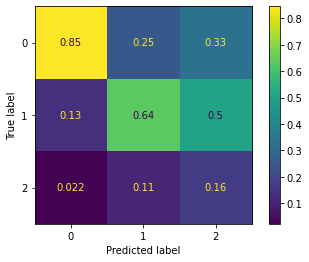

In [16]:
brf = BalancedRandomForestClassifier(n_estimators=200,
                                     random_state=0,
                                     sampling_strategy='not majority')
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(brf, X_test, y_test,normalize = 'pred')  # doctest: +SKIP
plt.show()

# Classificação Linhas com NaN

Nessa seção, aplicamos o método Random Forest com Oversampling, mas dessa vez sem a caluna 'Semanas_Utilizando',  de modo que as linhas com NaN possam ser classificadas

In [17]:
x_nan = Safra1819.drop(['Identificador_Agricultor','Semanas_Utilizando','dano_na_plantacao'], axis=1)
y_nan = Safra1819.iloc[:,-1]
print("Shape x of: %s" % str(np.shape(x_nan)))
print("Shape y of: %s" % str(np.shape(y_nan)))

X_train_nan, X_test_nan, y_train_nan, y_test_nan = train_test_split(
    x_nan, y_nan, test_size=0.3, random_state=0)

Shape x of: (80000, 7)
Shape y of: (80000,)


0.8305416666666666


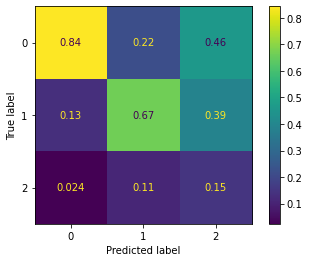

In [18]:
brf_nan = BalancedRandomForestClassifier(n_estimators=200,
                                     random_state=0,
                                     sampling_strategy='not majority')
brf_nan.fit(X_train_nan, y_train_nan) 
y_pred_nan = brf_nan.predict(X_test_nan)
print(accuracy_score(y_test_nan, y_pred_nan))

plot_confusion_matrix(brf_nan, X_test_nan, y_test_nan,normalize = 'pred')  # doctest: +SKIP
plt.show()

# Safra 2020

In [19]:
Safra20 = pd.read_csv('Safra_2020.csv', index_col=0)
Safra20.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
80000,SCROP80001,256,0,1,2,35,11.0,9,1
80001,SCROP80002,283,0,1,2,5,5.0,6,1
80002,SCROP80003,283,0,1,2,15,15.0,5,2
80003,SCROP80004,283,0,1,2,15,NaN,7,2
80004,SCROP80005,283,0,1,2,15,19.0,2,1


In [20]:
Safra20.nunique()

Identificador_Agricultor    8858
Estimativa_de_Insetos         71
Tipo_de_Cultivo                2
Tipo_de_Solo                   2
Categoria_Pesticida            3
Doses_Semana                  20
Semanas_Utilizando            62
Semanas_Sem_Uso               50
Temporada                      3
dtype: int64

In [21]:
Safra20.isnull().any()

Identificador_Agricultor    False
Estimativa_de_Insetos       False
Tipo_de_Cultivo             False
Tipo_de_Solo                False
Categoria_Pesticida         False
Doses_Semana                False
Semanas_Utilizando           True
Semanas_Sem_Uso             False
Temporada                   False
dtype: bool

In [22]:
print("Fração de linhas com valores faltantes %f" % (1 - len(Safra20.dropna())/len(Safra20)))

Fração de linhas com valores faltantes 0.106683


In [23]:
Safra20_notnan = Safra20.dropna().copy()
Safra20_nan = Safra20[Safra20.isna().any(axis=1)].copy()

# Classificação Safra20

In [24]:
y_pred20_notnan = brf.predict(Safra20_notnan.iloc[:,1:])
Safra20_notnan.loc[:,'previsao_dano_na_plantacao'] = y_pred20_notnan

y_pred20_nan = brf_nan.predict(Safra20_nan.drop(['Identificador_Agricultor','Semanas_Utilizando'], axis=1))
Safra20_nan.loc[:,'previsao_dano_na_plantacao'] = y_pred20_nan

Safra20_predicted = pd.concat([Safra20_notnan, Safra20_nan]).sort_index()

In [25]:
Safra20_predicted.to_csv('Safra_2020_predicted.csv')